In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [2]:
!pip install tensorflow==1.15.5
!pip install keras==2.3.1

In [3]:
import pandas as pd
import numpy as np
import keras
import pickle
import os
import cv2
import io
import boto3
import tensorflow as tf
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Markdown as md
import s3fs

Using TensorFlow backend.


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.5
2.3.1


### S3 Connection

In [ ]:
bucket_name = 'wongkj11-pda-plants'

In [ ]:
conn = boto3.client('s3')
# s3 = boto3.client('s3')
fs = s3fs.S3FileSystem()

In [ ]:
list_plant_classes_as_text = []
response = conn.list_objects_v2(Bucket = bucket_name, Prefix='', Delimiter='/')
for content in response.get('CommonPrefixes', []):
    plant_dir = content['Prefix'].split('/')[0]
    if plant_dir.upper() != '.DS_STORE':
        list_plant_classes_as_text.append(plant_dir)

dict_plant_classes = {}
for index, value in enumerate(list_plant_classes_as_text):
    if value.upper()!= 'PLANTVILLAGE':
        dict_plant_classes.update({ index: value })

In [ ]:
# pd.DataFrame.from_dict(dict_plant_classes, orient='index', columns=["PLANT_CLASS"]).to_csv("plant_classes.csv")

### Convert Image to Array

In [ ]:
def convert_image_to_array(image_loc):
    try:
        raw = fs.open(f'{image_loc}').read()
        if raw is None:
            return np.array([])
        else:
            np_image = cv2.imdecode(np.asarray(bytearray(raw)), cv2.IMREAD_COLOR)
            np_image_resize = cv2.resize(np_image, (256, 256))
            return np_image_resize
    except Exception as e:
        print(e)

def returnClassInteger(category):
    for key, value in dict_plant_classes.items():
        if category.upper() == value.upper():
            return key

### Load Images to List

In [ ]:
image_array_list, image_location_list, label_list = [], [], []
response = conn.list_objects_v2(Bucket = bucket_name, Prefix='', Delimiter='/')
for content in response.get('CommonPrefixes', []):
    plant_dir = content['Prefix'].split('/')[0]
    print(f"[PROCESSING]...{plant_dir}")
    contents = conn.list_objects(Bucket = bucket_name, Prefix = plant_dir)['Contents']
    for img_loc in contents[:150]:
        if img_loc['Key'].upper().endswith('.JPG'):
            image_array_list.append(convert_image_to_array(f"s3://{bucket_name}/{img_loc['Key']}"))
            image_location_list.append(f"{img_loc['Key']}")
            label_list.append(returnClassInteger(plant_dir))
print(f"[COMPLETE]...")

In [ ]:
# Pickling the Image Locaiton List

# with open("image_location_list.txt", "wb") as fp:   #Pickling
#     pickle.dump(image_location_list, fp)

In [ ]:
# Unpickling the Image Location List

# with open("image_location_list.txt", "rb") as fp:   # Unpickling
#     image_location_list = pickle.load(fp)

### Coverting List to NumPy Array

In [ ]:
np_features = np.c_[image_array_list].astype(np.uint8)
np_labels = np.c_[label_list].astype(np.uint8)

### Test-Train Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_features, np_labels, test_size = 0.2, random_state = 42)

### Normalize the Feature data

In [ ]:
x_train_norm = x_train/255
x_test_norm = x_test/255

### One-hot Encode the Label Data

In [ ]:
y_cat_train = to_categorical(y_train, len(dict_plant_classes))
y_cat_test = to_categorical(y_test, len(dict_plant_classes))

### Configure the Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="VALID", strides=(1, 1), input_shape=(256,256,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="VALID", strides=(1, 1), input_shape=(256,256,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(len(dict_plant_classes), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

### Train the Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 2)

model.fit(x_train_norm, y_cat_train, epochs = 15, validation_data = (x_test_norm, y_cat_test), callbacks = [early_stop])

### Metrics

In [ ]:
model.history.history

In [ ]:
pd.DataFrame.from_dict(model.history.history, orient='index', 
                       columns=["EPOCH_1","EPOCH_2","EPOCH_3","EPOCH_4","EPOCH_5","EPOCH_6"])

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics

metrics[['acc','val_acc']].plot();

metrics[['loss','val_loss']].plot();

model.evaluate(x_test_norm, y_cat_test)

### Prediction Performance

In [ ]:
predictions = model.predict_classes(x_test_norm)

In [ ]:
print(classification_report(y_test, predictions))

### Predict an Image

In [ ]:
print(f'Total Images: {len(image_location_list)}\n')
img_loc = image_location_list[8659]

print(f'Full Image Filepath: {img_loc}\n')
md(f"<h3>[ACTUAL CATEGORY]: &nbsp;&nbsp;&nbsp;{img_loc.split('/')[0]}</h1>")

In [ ]:
my_image = convert_image_to_array(f"s3://{bucket_name}/{img_loc}")
plt.imshow(my_image);

In [ ]:
predicted_value = model.predict_classes(my_image.reshape(1,256,256,3))[0]
cat_labels_df = pd.DataFrame(dict_plant_classes.items(), columns=['Predicted_Value', 'Category'])
predicted_class = cat_labels_df.loc[cat_labels_df.Predicted_Value == predicted_value, 'Category'].iloc[0]
md(f"<h3>[PREDICTED CATEGORY]: &nbsp;&nbsp;&nbsp;{predicted_class} ({predicted_value})</h1>")

In [ ]:
cat_labels_styled = pd.DataFrame(dict_plant_classes.items(), columns=['Predicted_Value', 'Category']).style.hide_index()

### Saving the Model

In [ ]:
model.save_weights(f"pda_weights_150.h5")

In [ ]:
# Save Neural Network structure to JSON (no weights)
model_json = model.to_json()
with open('pda_model_150.json', "w") as json_file:
    json_file.write(model_json)

# DEPLOYING MODEL TO SAGEMAKER ENDPOINT

In [ ]:
num_of_images = '150'
pda_model_name = f'pda_model_{num_of_images}.json'
pda_weights_name = f'pda_weights_{num_of_images}.h5'

### STEP ONE: Set Up

In [ ]:
import boto3
import re
from sagemaker import get_execution_role

### STEP TWO: Load the Keras Model using the json and weights file

In [ ]:
import keras
from keras.models import model_from_json

In [ ]:
role = get_execution_role()

In [ ]:
# !mkdir keras_model

In [ ]:
!mv pda_model_150.json keras_model
!mv pda_weights_150.h5 keras_model

In [ ]:
!ls keras_model

In [ ]:
import tensorflow as tf

json_file = open('/home/ec2-user/SageMaker/TF1_PROJ/keras_model/' + pda_model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform})

In [ ]:
loaded_model.load_weights(f'/home/ec2-user/SageMaker/TF1_PROJ/keras_model/{pda_weights_name}')
print("loaded model from disk")

### STEP THREE: Export the Keras Model to the TensorFlow Protocol Buffer format

In [ ]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

model_version = '1'
export_dir = 'export/Servo/' + model_version

In [ ]:
import shutil
shutil.rmtree(export_dir)

In [ ]:
build = builder.SavedModelBuilder(export_dir)

In [ ]:
tf.compat.v1.disable_eager_execution()
signature = predict_signature_def(inputs = {"inputs": loaded_model.input}, outputs = {"score": loaded_model.output})

In [ ]:
from keras import backend as K

with K.get_session() as sess:
    build.add_meta_graph_and_variables(
        sess = sess, tags = [tag_constants.SERVING], signature_def_map = {"serving_default": signature}
    )
    build.save()

In [ ]:
!ls export/Servo/1/variables

### STEP FOUR: Tar the entire directory and upload to S3

In [ ]:
import tarfile

with tarfile.open(f'model_{num_of_images}.tar.gz', mode = 'w:gz') as archive:
    archive.add('export', recursive = True)

In [ ]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path = f'model_{num_of_images}.tar.gz', key_prefix = 'model')

In [ ]:
print(f"Bucket name is: {sagemaker_session.default_bucket()}")

### STEP 5: Deploy the trained model

In [ ]:
# Create empty train.py file
!touch train.py

In [ ]:
from sagemaker.tensorflow.model import TensorFlowModel

sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + f'/model/model_{num_of_images}.tar.gz', role = role, framework_version = '1.15', entry_point = 'train.py')

### STEP 6: Host the SageMaker model and create Endpoint to access the Model

This step can take up to ~10 minutes

In [ ]:
%%time

# Deploy a SageMaker to an endpoint

predictor = sagemaker_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
print(f"Our Enpoint is called: {predictor.endpoint}")

### STEP 7: Make predictions to Endpoint

In [ ]:
from sagemaker.tensorflow.serving import Predictor

predictor = Predictor(endpoint_name = "tensorflow-inference-2021-08-19-01-58-58-303")

In [ ]:
import cv2
import numpy as np

img_loc = image_location_list[98]
bucket_name = 'wongkj11-pda-plants'

full_image_path = f"s3://{bucket_name}/{img_loc}"
full_image_path

In [ ]:
headers = {"content-type": "application/json"}

In [ ]:
raw = fs.open(f'{full_image_path}').read()

In [ ]:
raw

In [ ]:
np_image = cv2.imdecode(np.asarray(bytearray(raw)), cv2.IMREAD_COLOR)

In [ ]:
image_content = np_image.astype('uint8').tolist()

In [ ]:
body = {"instances": [{"inputs": image_content}]}

In [ ]:
try:
    results = predictor.predict(body)
    print(results)
except Exception as e:
    print(e)

In [ ]:
def returnClassInteger(num):
    for key, value in dict_plant_classes.items():
        if num == key:
            return value

In [ ]:
df = pd.DataFrame(results['predictions'][0], columns=['classes'])

In [ ]:
category = int(df.loc[df.classes == 1, :].index[0])

In [ ]:
print(f"Category = {returnClassInteger(category)}, {category}")

In [ ]:
dict_plant_classes

In [5]:
from PIL import Image
import io
import base64
import matplotlib.image as mpimg

In [ ]:
image_resized = Image.open(io.BytesIO(raw)).resize((256, 256), Image.ANTIALIAS)


In [ ]:
image_resized

In [ ]:
fp = io.BytesIO(bytearray(raw))

In [ ]:
fp

In [ ]:
mpimg.imread(fp, format = "jpeg")[:,:,::-1]

In [6]:
image_name = "river-pic.jpeg"

In [7]:
# Image.open(f'{image_name}').resize((256, 256), Image.ANTIALIAS)

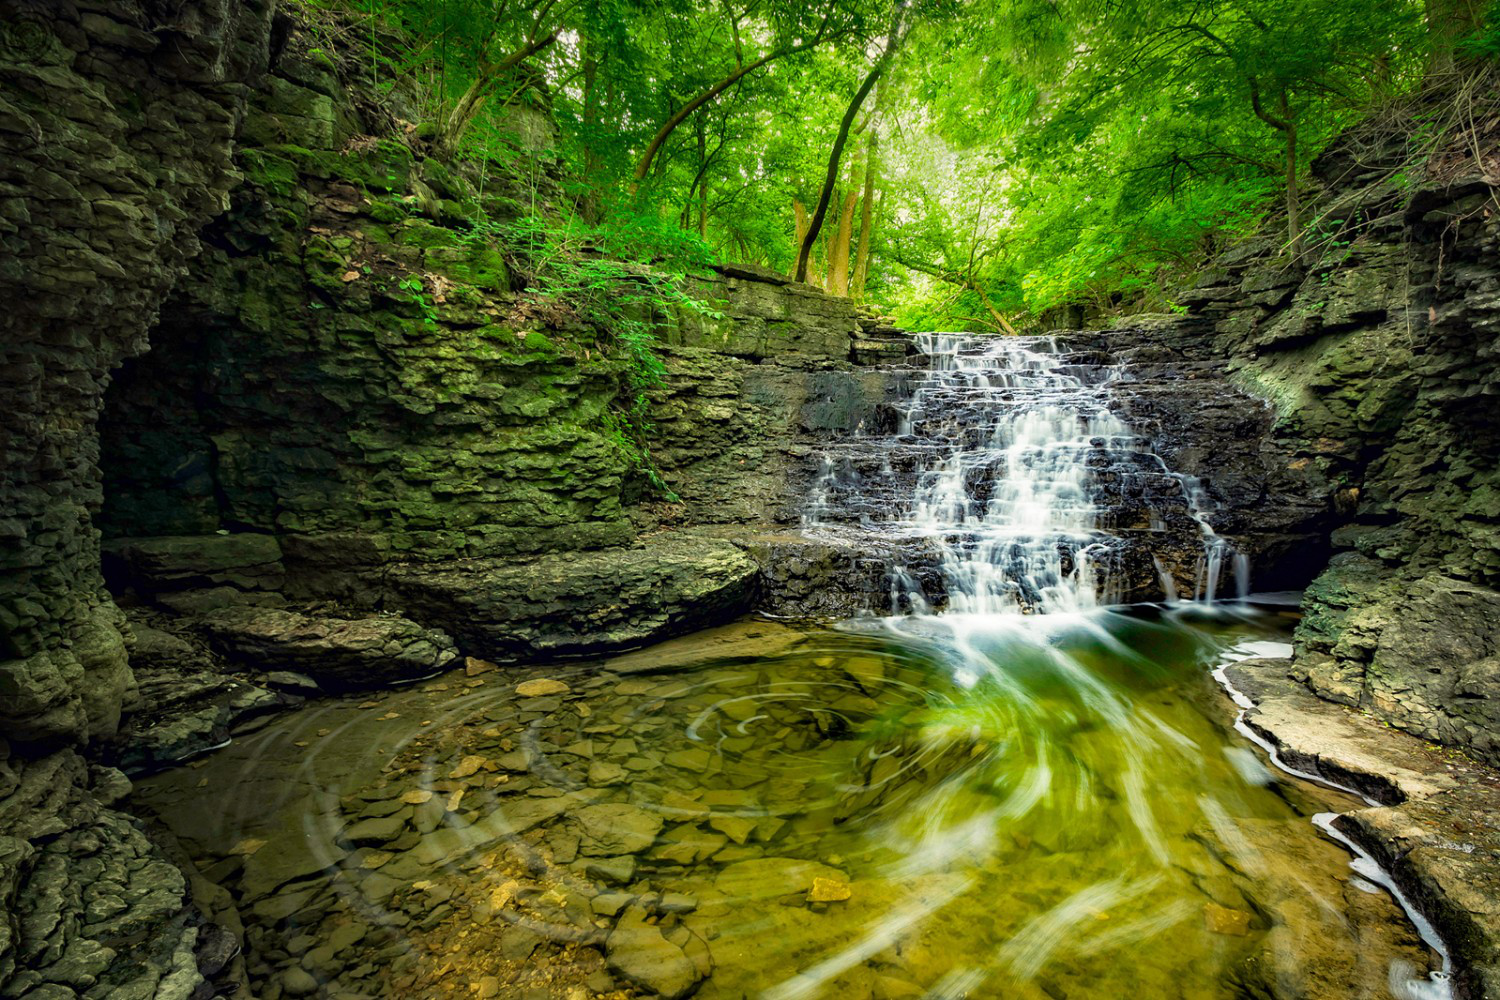

In [8]:
image_orig = Image.open(f'{image_name}')
image_orig

In [20]:
in_mem_file = io.BytesIO()

In [21]:
image_orig.save(in_mem_file, format = "JPEG")

In [22]:
in_mem_file.getValue()

AttributeError: '_io.BytesIO' object has no attribute 'getValue'

AttributeError: __array_interface__

In [15]:
mpimg.imread(in_mem_file, format = "jpeg")[:,:,::-1]

array([[[ 0,  1,  2],
        [ 0,  2,  3],
        [ 0,  4,  5],
        ...,
        [27, 85, 44],
        [ 7, 63, 22],
        [10, 66, 23]],

       [[ 0,  2,  3],
        [ 0,  3,  4],
        [ 1,  5,  6],
        ...,
        [20, 78, 37],
        [ 0, 57, 16],
        [ 0, 50,  7]],

       [[ 0,  3,  4],
        [ 0,  4,  5],
        [ 2,  6,  7],
        ...,
        [ 4, 64, 23],
        [ 1, 60, 16],
        [ 0, 58, 14]],

       ...,

       [[ 8,  2,  0],
        [ 9,  3,  0],
        [ 9,  3,  0],
        ...,
        [33, 68, 64],
        [35, 69, 68],
        [39, 76, 74]],

       [[11,  0,  0],
        [12,  1,  0],
        [12,  3,  0],
        ...,
        [43, 76, 72],
        [37, 72, 68],
        [41, 75, 74]],

       [[17,  5,  1],
        [16,  4,  0],
        [15,  3,  0],
        ...,
        [37, 70, 66],
        [28, 63, 59],
        [30, 65, 61]]], dtype=uint8)

In [ ]:
conn.upload_fileobj(
    in_mem_file, # This is what i am trying to upload
    "wongkj11-pda-image-upload",
    "new-plant-image.jpeg"
)

In [ ]:
image_resized

In [ ]:
mpimg.imread(fp, format = "jpeg")[:,:,::-1]

In [36]:
with open(image_name, "rb") as image:
    img_file = image.read()
    img_byte = bytearray(img_file)
    # From here
    img_resized = Image.open(io.BytesIO(img_byte)).resize((256, 256), Image.ANTIALIAS)
    in_mem_file = io.BytesIO()
    img_resized.save(in_mem_file, format = "JPEG")
    print(in_mem_file.getvalue())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\

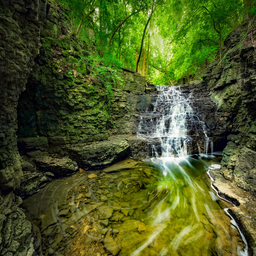

In [35]:
img_resized

In [ ]:
in_mem_file.read()

In [ ]:
in_mem_file.read()

In [ ]:
base64.b64decode(image_resized)

In [ ]:
fp = io.BytesIO(bytearray(in_mem_file.read()))

In [ ]:
fp

In [ ]:
mpimg.imread(in_mem_file, format = "jpeg")[:,:,::-1]

In [ ]:
fs.open("x_river-pic.jpeg").read()